<a href="https://colab.research.google.com/github/someshkr/Geo-Copula/blob/main/earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopy
!pip install geopandas
!pip install shapely
!pip install fiona
!pip install pyproj 
!pip install rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 23.2 MB/s 
     |████████████████████████████████| 16.7 MB 31.2 MB/s 
     |████████████████████████████████| 6.3 MB 38.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 24.0 MB/s 


In [2]:
import tensorflow as tf
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import rtree
import shapely
import fiona
import pyproj


In [3]:
df = pd.read_excel("/content/query.xlsx")
# df = pd.read_csv("/dbfs/FileStore/data/Indian_earthquake_data.csv")
df['time'] = pd.to_datetime(df['time'],utc=True)
df = df[['time','latitude','longitude','depth','mag']]
df = df.sort_values(by='time',ascending=True)
df.head()

,time,latitude,longitude,depth,mag
17836,2000-09-17 05:18:04.270000+00:00,38.006,140.670,105.1,4.5
17835,2000-09-17 21:04:24.900000+00:00,30.257,138.392,445.6,4.3
17834,2000-09-21 22:43:24.770000+00:00,35.811,140.837,45.2,4.8
17833,2000-09-23 17:42:10.600000+00:00,41.444,142.217,63.9,4.3
17832,2000-09-25 16:22:01.020000+00:00,32.167,142.461,33.0,4.1


In [4]:
df_train = df.iloc[:12512]
df_val = df.iloc[12512:14271]
df_test = df.iloc[14271:]
df_train = df_train.set_index('time')
df_val = df_val.set_index('time')
df_test = df_test.set_index('time')

In [5]:
x_train,y_train= df_train[['latitude','longitude','depth']],df_train[['mag']]
x_test,y_test= df_test[['latitude','longitude','depth']],df_test[['mag']]
x_val,y_val  = df_val[['latitude','longitude','depth']],df_val[['mag']]

In [6]:
batch_size = 32
buffer_size = x_train.shape[0]
# Provide an infinite dataset
x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
train_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_train), np.array(y_train))).shuffle(buffer_size).batch(batch_size).repeat()
# Provide an infinite dataset
val_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_val), np.array(y_val))).batch(batch_size).repeat()
test_iterator = tf.data.Dataset.from_tensor_slices((np.array(x_test), np.array(y_test))).batch(batch_size).repeat()

In [7]:
n_steps = x_train.shape[-2]
n_features = x_train.shape[-1]
# Define the model
model = Sequential()
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
#model.add(tf.keras.layers.Reshape((128, 1), input_shape = (128, )))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mse')

In [8]:
n_steps,n_features

(3, 1)

In [9]:
# train_iterator
# X = X.reshape((X.shape[0], X.shape[1], n_features))

In [10]:
epochs = 10
steps_per_epoch = 800
validation_steps = 80
# Train with an infinite dataset
history = model.fit(train_iterator, epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_iterator,
                    validation_steps=validation_steps)
print('=======================')
model.summary()

Epoch 1/10
800/800 [==============================] - 23s 17ms/step - loss: 0.4210 - val_loss: 0.1470
Epoch 2/10
800/800 [==============================] - 9s 11ms/step - loss: 0.2324 - val_loss: 0.1376
Epoch 3/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2327 - val_loss: 0.1570
Epoch 4/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2365 - val_loss: 0.1395
Epoch 5/10
800/800 [==============================] - 5s 6ms/step - loss: 0.2332 - val_loss: 0.1443
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.2335 - val_loss: 0.1457
Epoch 7/10
800/800 [==============================] - 12s 15ms/step - loss: 0.2322 - val_loss: 0.1467
Epoch 8/10
800/800 [==============================] - 11s 14ms/step - loss: 0.2318 - val_loss: 0.1389
Epoch 9/10
800/800 [==============================] - 6s 8ms/step - loss: 0.2334 - val_loss: 0.1383
Epoch 10/10
800/800 [==============================] - 8s 9ms/step - loss: 0.2302 - val_loss

In [11]:
# epochs = 10
# steps_per_epoch = 800
# validation_steps = 80
# # Train with an infinite dataset
# x_train = np.array(x_train)
# x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
# history = model.fit(x_train, y_train,epochs=epochs,
#                     steps_per_epoch=steps_per_epoch
#                    )
# print('=======================')
# model.summary()

In [12]:

#for batch_num, (x, y) in enumerate(test_iterator.take(3)):
  
len(model.predict(np.array(x_test)).reshape(-1))

3566

In [13]:

# yhat = model.predict(np.array(x_test), verbose=0).reshape(-1)


In [14]:
x_test.shape

(3566, 3, 1)

In [15]:
df_final = df_test.copy()
df_final['yhat']=model.predict(np.array(x_test)).reshape(-1)

In [16]:
df_final.head()

,latitude,longitude,depth,mag,yhat
time,,,,,
2016-10-20 02:49:53.120000+00:00,35.8196,140.5082,18.91,5.3,4.544724
2016-10-20 19:07:26.450000+00:00,41.9161,140.8357,154.05,4.2,4.160340
2016-10-21 05:07:22.990000+00:00,35.3743,133.8092,5.63,6.2,4.335525
2016-10-21 05:30:07.340000+00:00,35.5001,133.5914,10.00,4.1,4.351958
2016-10-21 05:33:58.790000+00:00,35.3563,133.8545,10.00,4.0,4.349107


In [17]:
# # univariate lstm example
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 3
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)

# # reshape from [samples, timesteps] into [samples, timesteps, features]
# n_features = 1
# print('++++++++++++++++++++++++++++++++++++++++++++++++')
# print(X.shape)
# X = X.reshape((X.shape[0], X.shape[1], n_features))
# print(X.ndim)
# # define model
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=200, verbose=0)
# # demonstrate prediction
# x_input = array([70, 80, 90])
# x_input = x_input.reshape((1, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)

In [18]:
from sklearn.cluster import AgglomerativeClustering

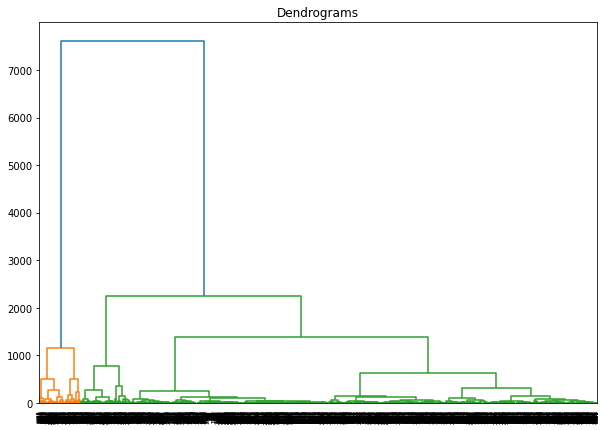

In [19]:
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
df_dend = df_final.drop(['mag'],axis=1) 
dend = shc.dendrogram(shc.linkage(df_dend, method='ward'))

In [20]:
cluster = AgglomerativeClustering(n_clusters=4).fit(df_dend)
df_dend['labels'] = cluster.labels_

In [21]:
df_dend.head()

,latitude,longitude,depth,yhat,labels
time,,,,,
2016-10-20 02:49:53.120000+00:00,35.8196,140.5082,18.91,4.544724,3
2016-10-20 19:07:26.450000+00:00,41.9161,140.8357,154.05,4.160340,2
2016-10-21 05:07:22.990000+00:00,35.3743,133.8092,5.63,4.335525,3
2016-10-21 05:30:07.340000+00:00,35.5001,133.5914,10.00,4.351958,3
2016-10-21 05:33:58.790000+00:00,35.3563,133.8545,10.00,4.349107,3


In [34]:
df_1 = df_dend.loc[(df_dend['labels']==0)]
df_2 = df_dend.loc[(df_dend['labels']==1)]
df_3 = df_dend.loc[(df_dend['labels']==2)]
df_4 = df_dend.loc[(df_dend['labels']==3)]

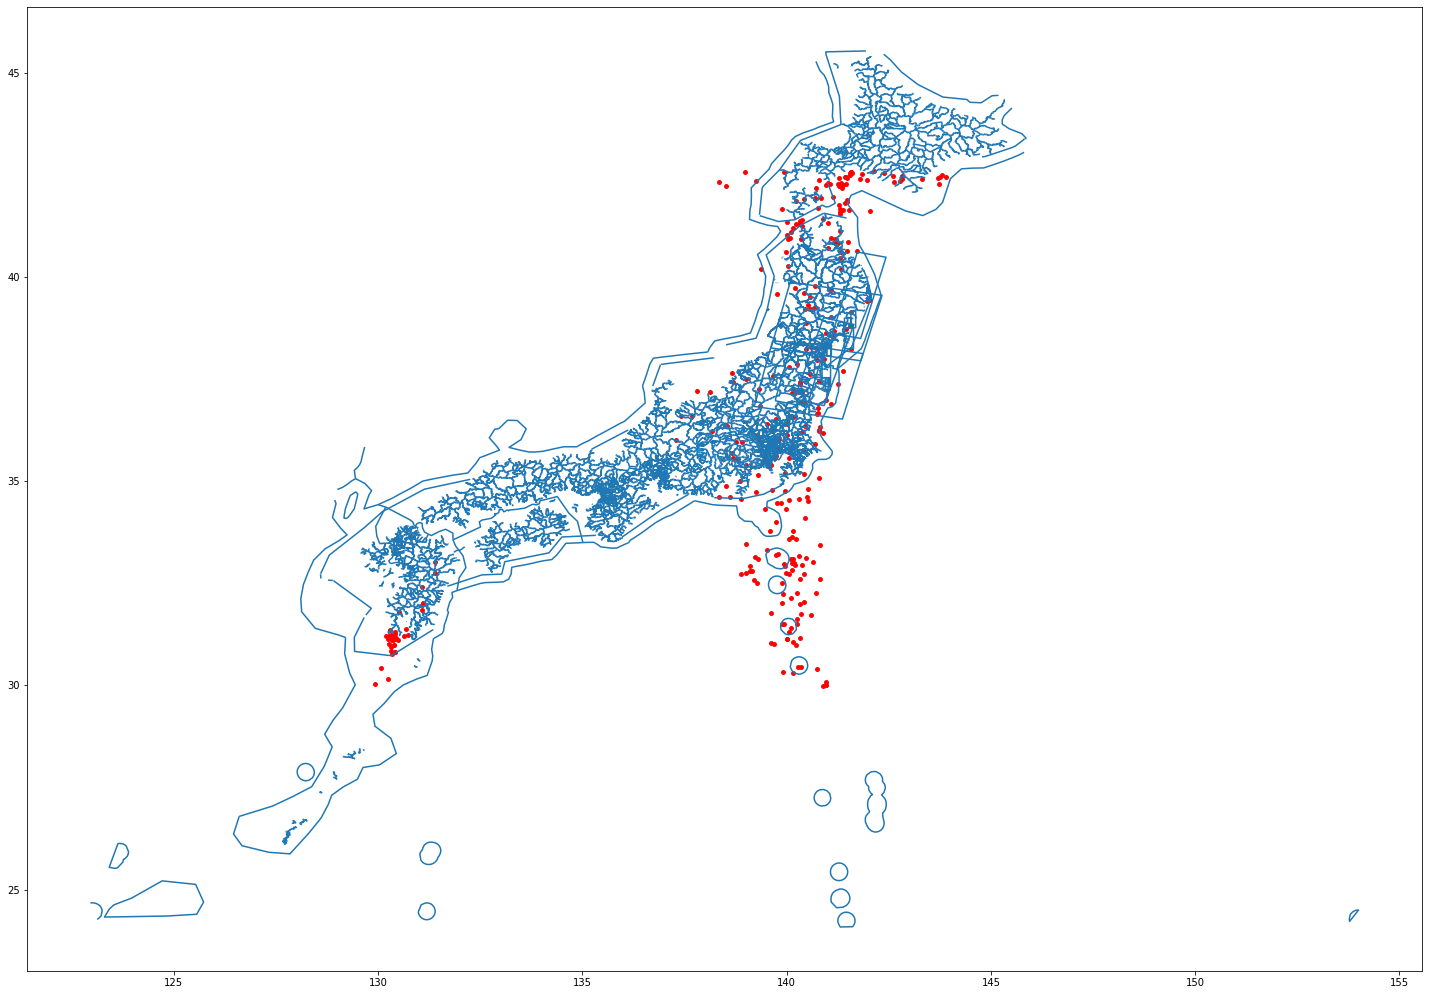

In [31]:
import fsspec


with fsspec.open("/content/japan_administrative.zip") as file:
    jap = gpd.read_file(file)


geometry = [Point(xy) for xy in zip(df_1['longitude'],df_1['latitude'])]
gdf = GeoDataFrame(df_1,geometry=geometry)
gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='red', markersize=15);

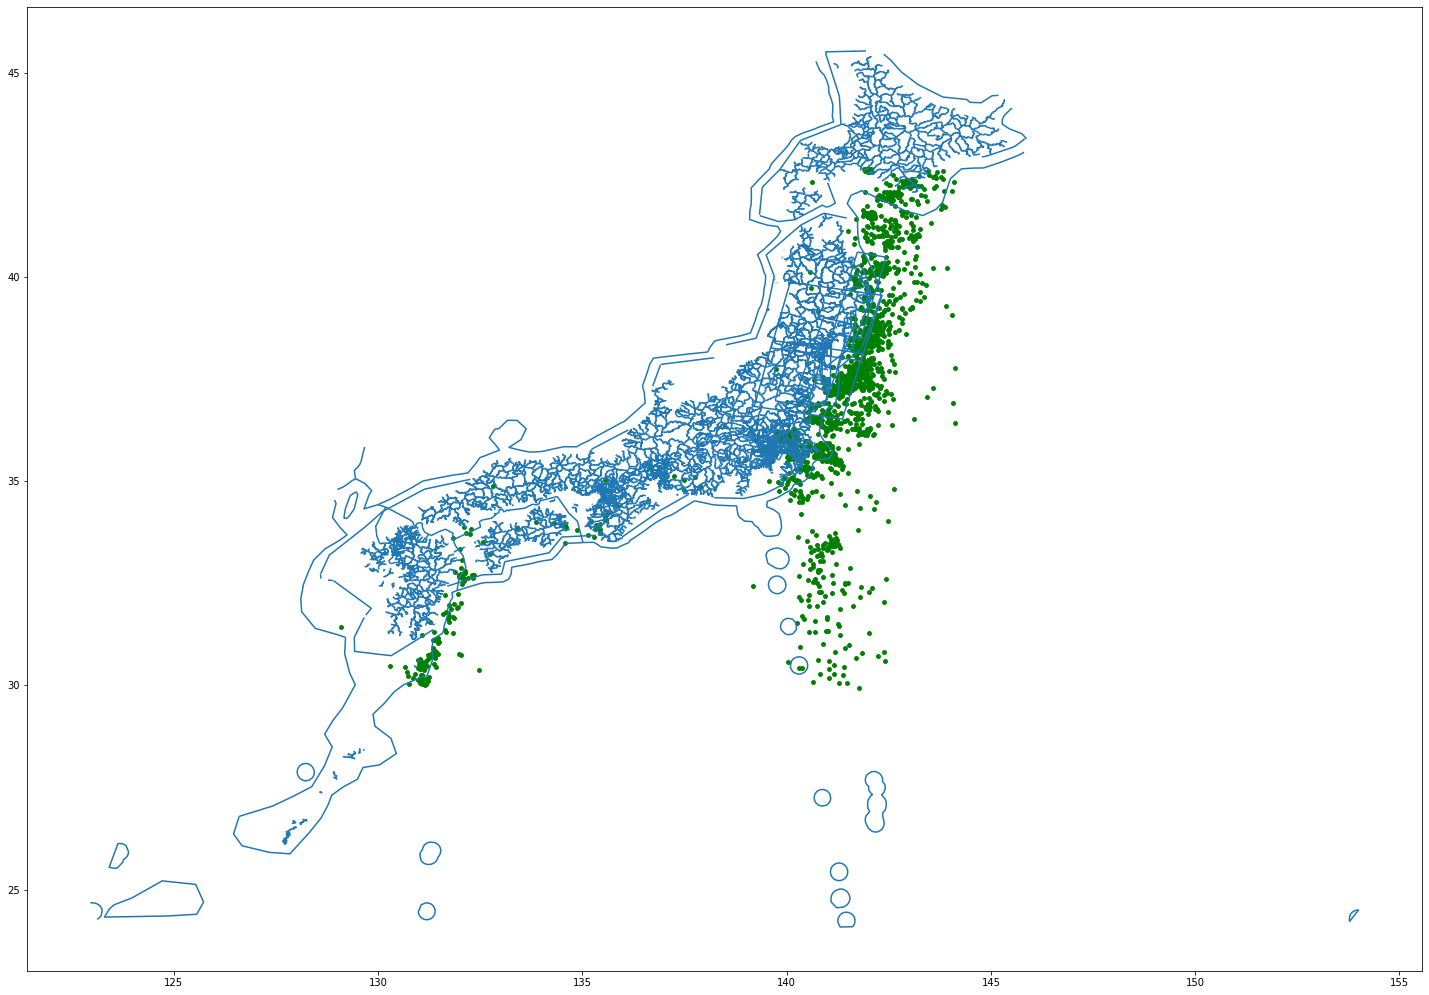

In [35]:
geometry = [Point(xy) for xy in zip(df_2['longitude'],df_2['latitude'])]
gdf = GeoDataFrame(df_2,geometry=geometry)
gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='o', color='Green', markersize=15);

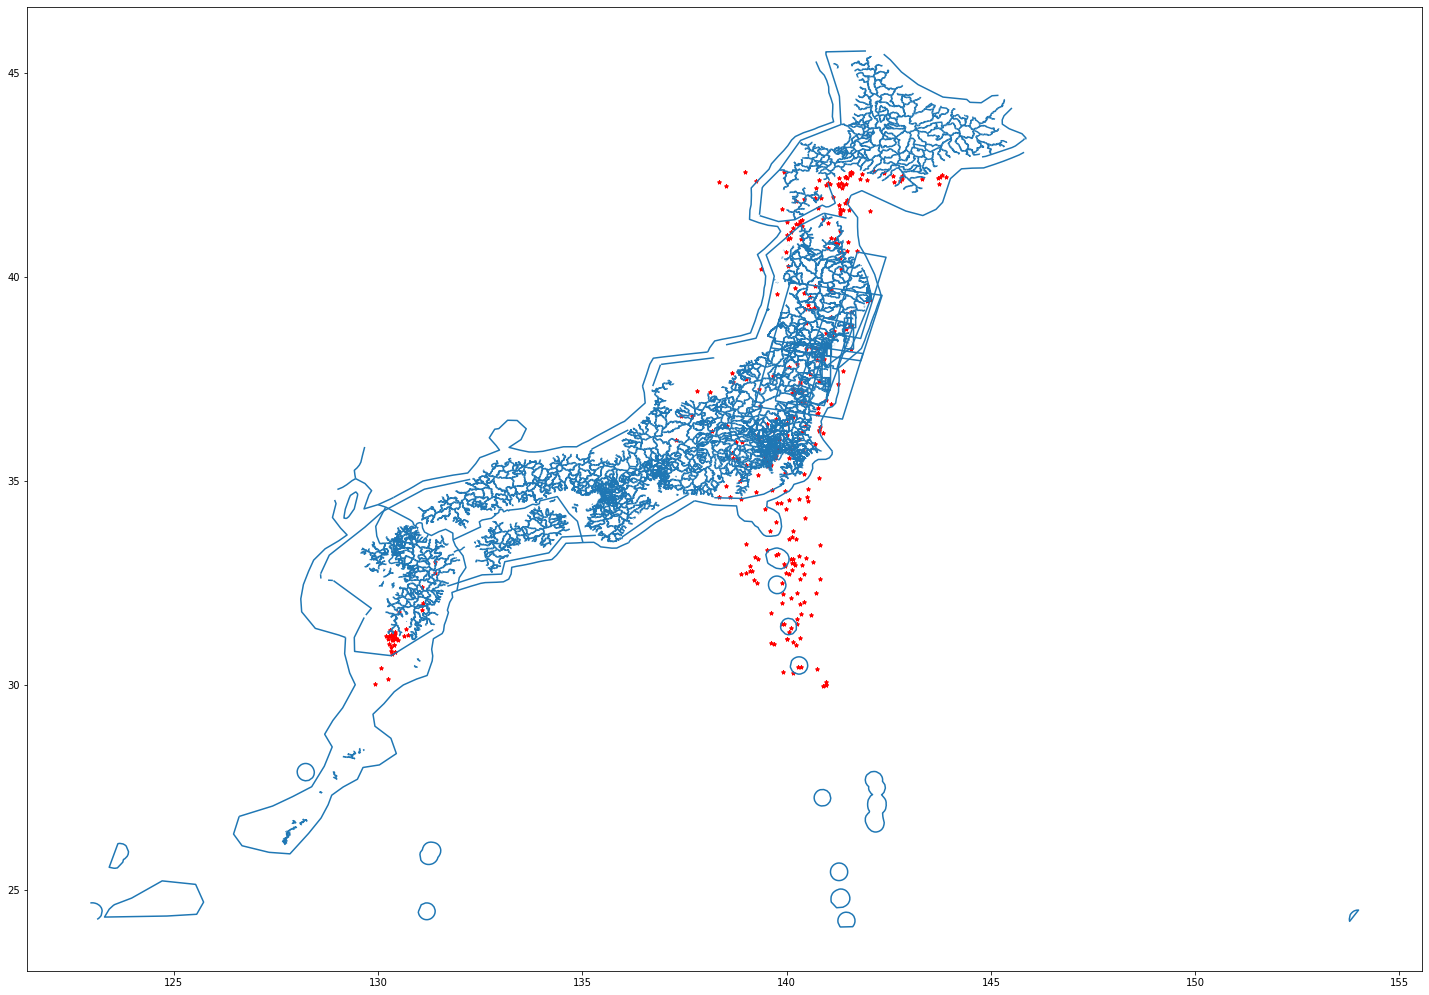

In [36]:


geometry = [Point(xy) for xy in zip(df_3['longitude'],df_3['latitude'])]
gdf = GeoDataFrame(df_3,geometry=geometry)
gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='*', color='red', markersize=15);

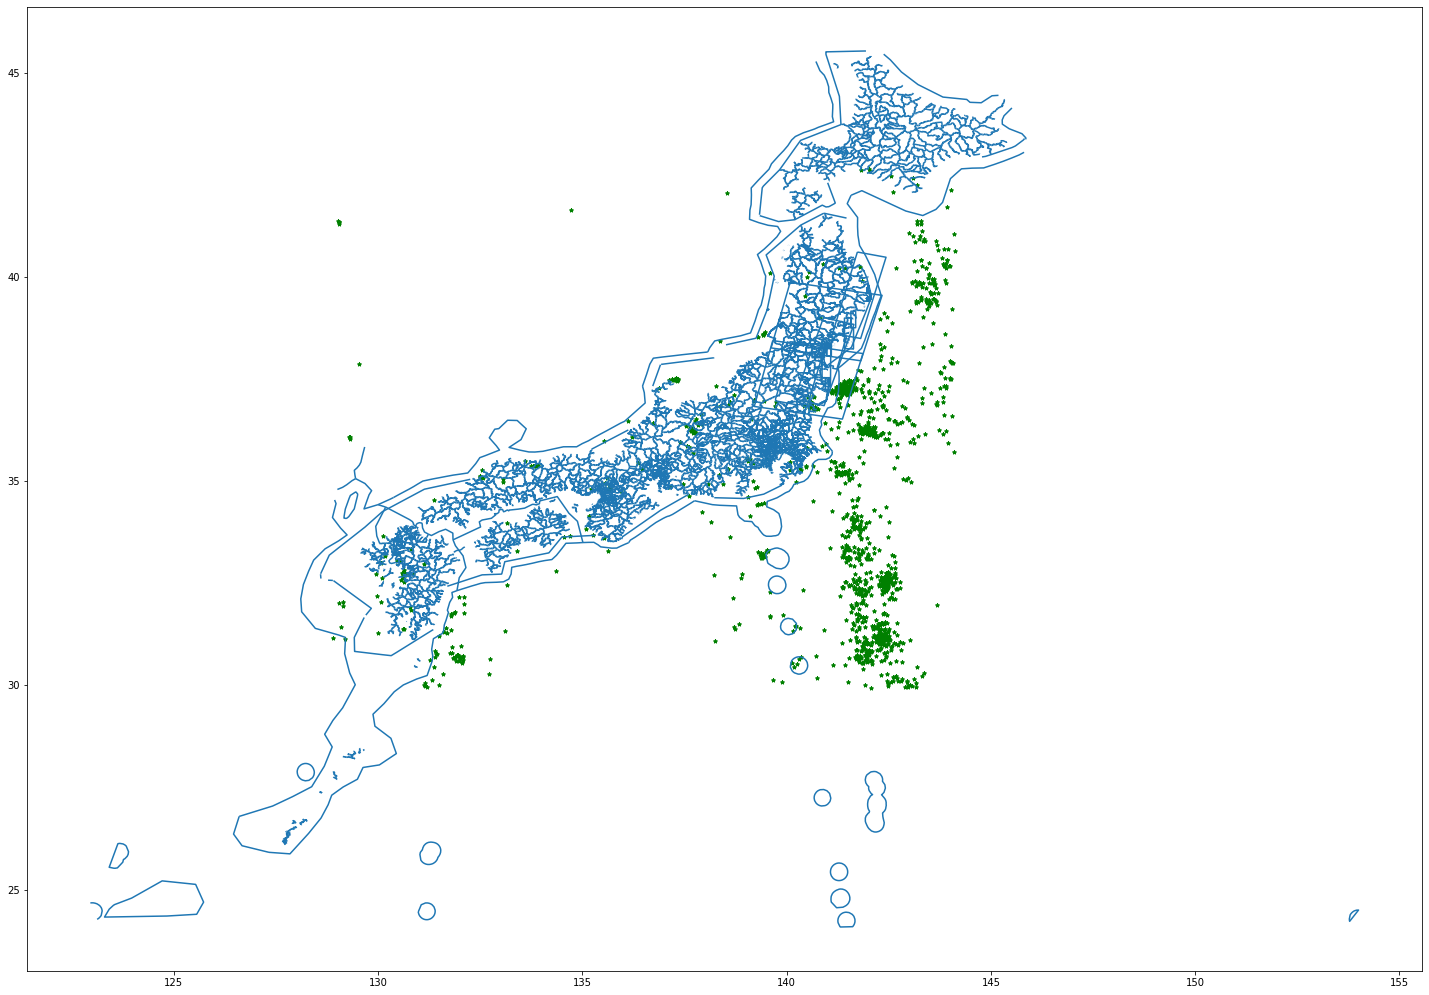

In [37]:


geometry = [Point(xy) for xy in zip(df_4['longitude'],df_4['latitude'])]
gdf = GeoDataFrame(df_4,geometry=geometry)
gdf.plot(ax=jap.plot(figsize=(25, 25)), marker='*', color='green', markersize=15);